In [40]:
import os, subprocess 

import pandas as pd 

from ftplib import FTP
from tqdm import tqdm 
from multiprocessing import Pool

## 1. Run kallisto on reads of Aedes aegypti
    1. Collect TSA master file 
    2. Make Kallisto index
    3. Write Kallisto quant command lines in a bash script
    4. Use python Pool to multithread it

In [41]:
concurent_jobs = 4

In [42]:
path = "/home/xqua/data"

In [45]:
def collect_urls(tsa_id):
    url_list = []
    prefix = tsa_id[:2]
    suffix = tsa_id[2:4]
    print('Getting data URLs...')
    ftp = FTP('ftp.ncbi.nih.gov')
    ftp.login()

    url_base = f'/sra/wgs_aux/{prefix}/{suffix}/{tsa_id}/'
    ftp.cwd(url_base)
    for i in range(2):
        i += 1 
        url = f'{url_base}{tsa_id}.{i}.fsa_nt.gz'
        url_list.append(url)
    return url_list

        
def get_tsa_data(tsa_id, folder_output):
    tsa = []
    urls = collect_urls(tsa_id)
    for url in urls:
        file_name = url.split('/')[-1]
        print(f'Downloading rsync://ftp.ncbi.nlm.nih.gov{url} {folder_output}')
        print(f'rsync --copy-links --recursive --times --verbose rsync://ftp.ncbi.nlm.nih.gov{url} {folder_output}')
        tsa.append(file_name)
    return tsa 


def build_tsa_input():
    folder_base = os.path.join(path,'/Oskar_Evolution')
    folder_output = f'{folder_base}/Data/02_Oskar_analyses/2.12/aedes_aegypti/'
    tsa = get_tsa_data('GFNA01', folder_output)

    os.chdir('..')
    os.chdir(folder_output)
    transcript_output = 'GFNA01_transcripts.fasta.gz'
    if os.path.isfile(f'{folder_output}{transcript_output}'):
        print(f'{transcript_output} already generated')
    else: 
        print('\n\nGenerating TSA master file')
        cmd = f'zcat {tsa[0]} {tsa[1]} > {transcript_output.replace(".gz", "")}'
        subprocess.run(cmd, shell=True)
        subprocess.run(f'gzip {transcript_output.replace(".gz", "")}', shell=True)
        
        
def run_kallisto_index():
    folder_base = os.path.join(path,'/Oskar_Evolution')
    folder_output = f'{folder_base}/Data/02_Oskar_analyses/2.12/aedes_aegypti/'
    transcripts_gz = 'GFNA01_transcripts.fasta.gz'
    transcripts_idx = 'GFNA01_transcripts.idx'
    print(f'\nBuilding index for {transcripts_gz.replace(".gz", "")}')
    cmd = f'kallisto index -i {transcripts_idx} {transcripts_gz}'
    print(f'Run ${cmd} in {folder_output} and move to {path}')
    # subprocess.run(cmd, shell=True)
    
            
def kallisto_quant_cmds():
    os.chdir(path)
    if not os.path.isdir(f'{os.getcwd()}/quant/'):
        os.mkdir(f'{os.getcwd()}/quant/')
    index = f'{os.getcwd()}/GFNA01_transcripts.idx'
    fastq_folders = '/home/xqua/bucket/'
    for folder in tqdm(os.listdir(fastq_folders)):
        if '.csv' in folder :
            sra_table_info = pd.read_csv(os.path.join(fastq_folders, folder), sep=',')
            library_layout = sra_table_info[['Run', 'LibraryLayout']]
    print('Writing bash command lines')
    f = open(f'{os.getcwd()}/all_kallisto_quant.sh', 'w')
    for run, layout in library_layout.values:
        fastq = ' '.join([ os.path.join(fastq_folders, run, file) for file in os.listdir(os.path.join(fastq_folders, run)) ])
        if layout == 'SINGLE':
            cmd = f'kallisto quant -i {index} -o {os.getcwd()}/quant/{run}_output --single -l 200 -s 20 {fastq}'
        if layout == 'PAIRED':
            cmd = f'kallisto quant -i {index} -o {os.getcwd()}/quant/{run}_output {fastq}'
        f.write(f'{cmd} \n')
    f.close()
    
def check_abundance_file():
    quant_path = os.path.join(path,'quant')
    
def run_kalisto(cmd):
    s = subprocess.run(cmd, capture_output=True)
    return s
    
def run_parallel():
    with open(f'{os.getcwd()}/all_kallisto_quant.sh') as f:
        commands = f.readlines()
        commands = [c.split() for c in commands]
    with Pool(concurent_jobs) as p:
        results = p.map(run_kalisto, commands)
    return results

In [46]:
# Main

In [54]:
build_tsa_input()
run_kallisto_index()
kallisto_quant_cmds()

Getting data URLs...
rsync --copy-links --recursive --times --verbose rsync://ftp.ncbi.nlm.nih.gov/sra/wgs_aux/GF/NA/GFNA01/GFNA01.1.fsa_nt.gz /home/xqua/data/Oskar_Evolution/Data/02_Oskar_analyses/2.12/aedes_aegypti/
rsync --copy-links --recursive --times --verbose rsync://ftp.ncbi.nlm.nih.gov/sra/wgs_aux/GF/NA/GFNA01/GFNA01.2.fsa_nt.gz /home/xqua/data/Oskar_Evolution/Data/02_Oskar_analyses/2.12/aedes_aegypti/
Generating TSA master file


100%|██████████| 148/148 [00:00<00:00, 20016.03it/s]


Building index for GFNA01_transcripts.fasta
Run $kallisto index -i GFNA01_transcripts.idx GFNA01_transcripts.fasta.gz in /home/xqua/data/Oskar_Evolution/Data/02_Oskar_analyses/2.12/aedes_aegypti/ and move to /home/xqua/data/
Writing bash command lines


In [ ]:
run_parallel()

In [59]:
#### Check number of abundance.tsv done

In [47]:
!find /home/xqua/data/quant/ -type f -name '*.tsv' -print | wc

    147     147    7938


# Analysis of Oskar abundance in tissues

This is the tissue types as defines by the authors: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4704297/

### Figure 2
![image](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4704297/bin/12864_2015_2239_Fig2_HTML.jpg)

## From DeSeq2 quantification by authors of study
The authors ran a DeSeq2 quantification pipeline accross their entire dataset, we are here analyzing their results

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.set_style("ticks")
plt.rc("axes.spines", top=False, right=False)
# Smallest context:
sns.set_palette("muted")
sns.set_context("poster")

In [17]:
!wget https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4704297/bin/12864_2015_2239_MOESM5_ESM.xlsx -O ../Data/02_Oskar_analyses/2.12/study_results.xlsx

--2021-08-11 12:17:37--  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4704297/bin/12864_2015_2239_MOESM5_ESM.xlsx
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21458460 (20M) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘../Data/02_Oskar_analyses/2.12/study_results.xlsx’

../Data/02_Oskar_an 100%[===================>]  20.46M  3.34MB/s    in 4.5s    

2021-08-11 12:17:42 (4.59 MB/s) - ‘../Data/02_Oskar_analyses/2.12/study_results.xlsx’ saved [21458460/21458460]



In [18]:
oskar_id_vectorbase = "AAEL000442"

In [20]:
metadata = pd.read_csv('../Data/02_Oskar_analyses/2.12/2.12_study_metadata.csv')
results = pd.read_excel('../Data/02_Oskar_analyses/2.12/study_results.xlsx')
oskar_deseq = results[results['Vectorbase Identifier'] == oskar_id_vectorbase].melt()[3:]
data = metadata.merge(oskar_deseq, left_on='Sample Name', right_on='variable')

In [21]:
# Removing a Hindleg sample that's way out, so probably a contamination from the abdominal tip or an egg
data = data[data['Run'] != "SRR1166486"]

In [22]:
def classify_tissue(x):
    if x == "brains" or x == "ovaries" or x == "abdominal tips":
        return x
    else:
        return 'other tissues'
data['clean_tissue'] = data['tissue'].apply(classify_tissue)

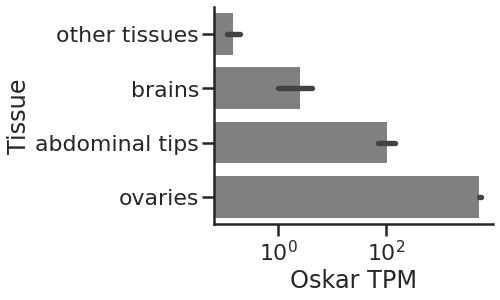

In [29]:
fig = plt.figure(figsize=(5,4))
sns.barplot(data=data, x='value', y='clean_tissue', ci=68, order=["other tissues", "brains", "abdominal tips", "ovaries"], color="gray")
plt.xscale('log')
plt.xlabel("Oskar TPM")
plt.ylabel("Tissue")
fig.savefig('../oskar_tissues.svg')

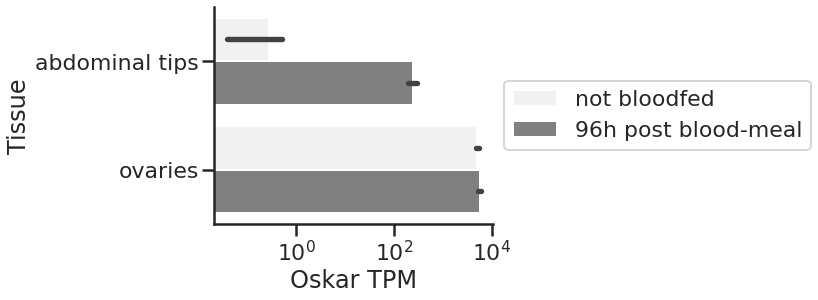

In [31]:
fig = plt.figure(figsize=(5,4))
sns.barplot(data=data[data['clean_tissue'].isin(["abdominal tips", "ovaries"])], x='value', y='clean_tissue', hue="bloodfeeding_state", ci=68, order=["abdominal tips", "ovaries"], color="gray")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.xlabel("Oskar TPM")
plt.ylabel("Tissue")
fig.savefig('../oskar_tissue_bloodfed.svg')

## Kalisto Quantification by us

In [36]:
import os

In [49]:
outputs = os.listdir('../../quant/')

In [51]:
oskar_id = "GFNA01357697.1"

In [56]:
metadata = pd.read_csv('../Data/02_Oskar_analyses/2.12/2.12_study_metadata.csv')

In [54]:
results = []
for output in outputs:
    tmp = [output[:10], 0]
    df = pd.read_table("../../quant/{}/abundance.tsv".format(output))
    tmp[1] = df[df['target_id'] == oskar_id]['tpm'].values[0]
    results.append(tmp)
results = pd.DataFrame(results, columns=['Run', 'Oskar'])

In [55]:
data = metadata[['Run', 'bloodfeeding_state', 'dev_stage', 'mating_state', 'Replicate', 'SAMPLE_TYPE', 'sex', 'tissue', 'treatment']].merge(results, on="Run")

In [58]:
def classify_tissue(x):
    if x == "brains" or x == "ovaries" or x == "abdominal tips":
        return x
    else:
        return 'other tissues'
data['clean_tissue'] = data['tissue'].apply(classify_tissue)

In [61]:
# Removing a Hindleg sample that's way out, so probably a contamination from the abdominal tip or an egg
data = data[data['Run'] != "SRR1166486"]

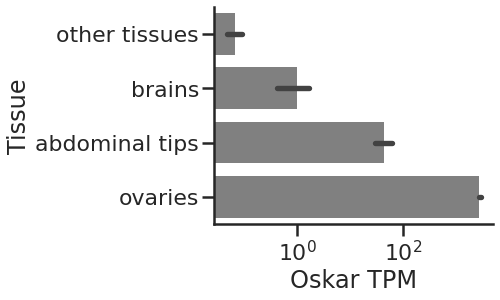

In [65]:
fig = plt.figure(figsize=(5,4))
sns.barplot(data=data, x='Oskar', y='clean_tissue', ci=68, order=["other tissues", "brains", "abdominal tips", "ovaries"], color="gray")
plt.xscale('log')
plt.xlabel("Oskar TPM")
plt.ylabel("Tissue")
fig.savefig('../oskar_tissues_kalisto.svg')

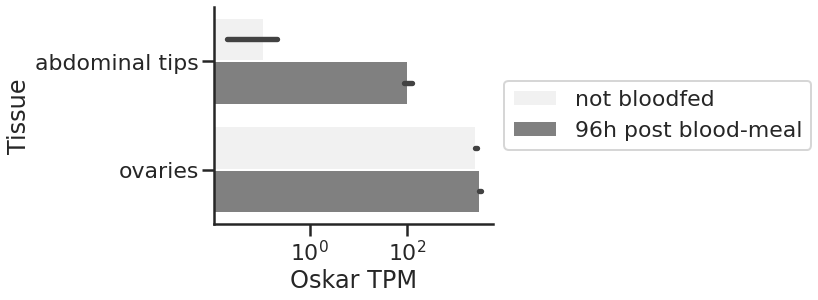

In [66]:
fig = plt.figure(figsize=(5,4))
sns.barplot(data=data[data['clean_tissue'].isin(["abdominal tips", "ovaries"])], x='Oskar', y='clean_tissue', hue="bloodfeeding_state", ci=68, order=["abdominal tips", "ovaries"], color="gray")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.xlabel("Oskar TPM")
plt.ylabel("Tissue")
fig.savefig('../oskar_tissue_bloodfed_kalisto.svg')